In [1]:
!pip install ray

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 59.4 MB 1.2 MB/s 
     |████████████████████████████████| 8.8 MB 38.3 MB/s 
     |████████████████████████████████| 4.1 MB 47.2 MB/s 
     |████████████████████████████████| 468 kB 69.3 MB/s 
  Attempting uninstall: grpcio
    Found existing installation: grpcio 1.48.1
    Uninstalling grpcio-1.48.1:
      Successfully uninstalled grpcio-1.48.1


In [2]:
# dataset
from torchvision import datasets

from functools import partial
import numpy as np
from copy import deepcopy

# visualization
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate

# preprocessing
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torch.utils.data import random_split

# model
import torch
from torch import nn
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau

# hyperparameter tuning
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler

# metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

# 1. Load Data & Preprocessing

**Dataset**: <a href="https://www.cs.toronto.edu/~kriz/cifar.html" target="_blank">CIFAR-10</a>

**Classes**: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck

The following transformations are used:
* **normalization**: from [0, 255] to [0, 1]
* **standardization**: by substracting the mean and dividing with std

In [3]:
def load_data(data_dir):
    """ Create train and test pytorch dataset objects from CIFAR-10.
    
    The following tranformations are applied on CIFAR-10:
        * normalization: from [0, 255] to [0, 1] by dividing with 255,
        * standardization: by substracting the mean and dividing with std
    
    Args:
        data_dir:
            directory where data will be saved, as a string.
    
    Returns:
        train and test dataset, as pytorch dataset objects.
    """
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.2435, 0.2616))
    ])

    trainset = datasets.CIFAR10(root=data_dir,
                                train=True, 
                                download=True, 
                                transform=transform)

    testset = datasets.CIFAR10(root=data_dir, 
                               train=False, 
                               download=True, 
                               transform=transform)

    return trainset, testset

In [4]:
trainset, testset = load_data(data_dir='cifar10')

print(f'\nTraining data:\n--------------\n{trainset}')
print(f'Test data:\n--------------\n{testset}')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting cifar10/cifar-10-python.tar.gz to cifar10
Files already downloaded and verified

Training data:
--------------
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: cifar10
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.2435, 0.2616))
           )
Test data:
--------------
Dataset CIFAR10
    Number of datapoints: 10000
    Root location: cifar10
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.2435, 0.2616))
           )


In [5]:
batch_size = 64

train_dataloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(testset, batch_size=batch_size, shuffle=False)

# 2. CNN Architecture

This Convolutional Neural Network follows the architecture of LeNet. However, instead of using Tanh activation function and average pooling, **ReLU activation function** and **max pooling** is used. Also, **dropout layers** and **batch normalization layers** have been added.

**Architecture:** Input &#8594; CONV1 &#8594; NORM1 &#8594; ReLU &#8594; POOL2 &#8594; CONV3 &#8594; NORM2 &#8594; ReLU &#8594; POOL4 &#8594; CONV5 &#8594; FC6 &#8594; Softmax

Convolutional layers:
* **CONV1**: 6 filters and kernel size of 5 x 5
* **CONV3**: 16 filters and kernel size of 5 x 5
* **CONV5**:120 filters and kernel size of 5 x 5

Pooling Layers:
* **POOL2, POOL4**: max pooling layers with receptive field of 2 x 2.

Activations:
* ReLU activation function **(hidden layer)**
* Softmax activation function **(output layer)**

Regularization:
* Weight decay (L2 regularization)
* Dropout layers

Normalization:
* Batch normalization

Loss Function:
* Cross Entropy Loss

Optimizer and Scheduler:
* Adam optimizer
* ReduceLROnPlateau scheduler

In [6]:
class CNN(nn.Module):
    """ Convolutional Neural Network for multiclass classification.
    
    This CNN follows the architecture of LeNet. However, instead of using 
    Tanh activation function and average pooling, ReLU activation function 
    and max pooling is used. Also, dropout layers and batch normalization layers have been added.
    
    The CNN architecture is as follows:
    Input → CONV1 → NORM1 → ReLU → POOL2 → CONV3 → NORM2 → ReLU → POOL4 → CONV5 → FC6 → Softmax
    
    The convolutional layers are configured as follows:
    * CONV1: 6 filters and kernel size of 5 x 5
    * CONV3: 16 filters and kernel size of 5 x 5
    * CONV5: 120 filters and kernel size of 5 x 5
    
    The pooling layers are configured as follwos:
    * POOL2, POOL4: max pooling layers with receptive field of 2 x 2.
    
    The hyperparameters of the CNN are:
    * probability of dropout layer.
    
    Arguments:
        in_channels:
            size of input, as an integer.
        output_size:
            size of output (number of labels), as an integer
        p:
            dropout probability, as a float.
    """
    
    def __init__(self, in_channels, output_size, p):
        """ Initialize Convolutional Neural Network.
        
        Args:
            in_channels:
                size of input, as an integer.
            output_size:
                size of output (number of labels), as an integer.
            p:
                dropout probability, as a float.
        """
        super(CNN, self).__init__()
        
        self.in_channels = in_channels
        self.output_size = output_size
        self.p = p
        
        # activation function
        self.activation = nn.ReLU()
        
        # convolutional layer: CONV1
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=6, kernel_size=5, stride=1)
        # convolutional layer: CONV3
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1)
        
        # max pooling layer 
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # dropout layer
        self.dropout = nn.Dropout(p)
        
        # batch normalization layer: NORM1
        self.norm1 = nn.BatchNorm2d(6)
        # batch normalization layer: NORM2
        self.norm2 = nn.BatchNorm2d(16)
        
        # fully connected layers
        self.fc1 = nn.Linear(in_features=16 * 5 * 5, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        self.fc3 = nn.Linear(in_features=84, out_features=output_size)
        
    def forward(self, x):
        # Input --> CONV1 --> NORM --> ReLU --> POOL2
        pre = self.conv1(x)
        normalized = self.norm1(pre)
        post = self.activation(normalized)
        x = self.pool(post)
        
        # CONV3 → NORM → ReLU → POOL4
        pre = self.conv2(x)
        normalized = self.norm2(pre)
        post = self.activation(normalized)
        x = self.pool(post)
        
        # flatten all dimensions except batch
        x = torch.flatten(x, 1)
        
        # CONV5
        logits = self.activation(self.fc1(x))
        logits = self.dropout(logits)
        
        # FC6
        logits = self.activation(self.fc2(logits))
        logits = self.dropout(logits)
        
        # outpout
        logits = self.fc3(logits)
        
        return logits

# 3. Hyperparameter Tuning

We'll use **early stopping** with **ASHAScheduler** to stop bad trials earlier.

|                               | Validation Loss | Validation Accuracy |
| :---------------------------: | :-------------: | :-----------------: |
| CNN                           | 1.01            | 65%                 |

Best trial **configuration** for CNN: p: 0.4, lr: 0.001, l2: 0.0001

In [7]:
def tune_helper(config, trainset, in_channels, num_labels, batch_size, epochs):
    """ Fit deep learning model and test it on a hold-out validation set.
    
    The validation set is a 20% hold-out set of the training set. 
    The loss function used is Cross Entropy Loss.
    The optimer used is Adam and the scheduler that wraps the optimizer is ReduceLROnPlateau.
    The metric used is accuracy score.
    
    Args:
        config:
            hyperparameters of neural network, as a dictionary.
        trainset:
            training dataset, as a pytorch object.
        in_channels:
            number of input channels, as an integer.
        num_labels:
            number of labels, as an integer.
        batch_size:
            size of batches to be processed, as an integer.
        epochs:
            number of epochs (times the neural network will see the data), as an integer.
    """
    model = CNN(in_channels=in_channels,
                output_size=num_labels,
                p=config['p'])
    
    # support data parallel training on multiple GPUs
    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
        if torch.cuda.device_count() > 1:
            model = nn.DataParallel(model)
    model.to(device)
    
    # loss function
    loss_fn = nn.CrossEntropyLoss()
    
    # optimizer
    optimizer = AdamW(model.parameters(), lr=config['lr'], weight_decay=config['l2'])
    
    #scheduler
    scheduler = ReduceLROnPlateau(optimizer, mode='min')
    
    # split data: training (80%) - validation (20%)
    test_abs = int(len(trainset) * 0.8)
    train_subset, val_subset = random_split(trainset, [test_abs, len(trainset) - test_abs])

    train_dataloader = DataLoader(train_subset,
                                  batch_size=batch_size,
                                  shuffle=True, 
                                  num_workers=2)
    
    val_dataloader = DataLoader(val_subset,
                                batch_size=batch_size,
                                shuffle=True,
                                num_workers=2)
    
    for epoch in range(epochs):
        # fit neural network on training data
        model.train()  # put on train mode
        for batch, (X, Y) in enumerate(train_dataloader, 0):
            # send the data to the GPU memory explicitly
            X, Y = X.to(device), Y.to(device)

            # reset the gradients
            optimizer.zero_grad()
            
            # compute prediction
            pred = model(X)

            # compute loss
            loss = loss_fn(pred, Y)

            # backpropagate
            loss.backward()

            # update parameters
            optimizer.step()
        
        # test on validation data
        val_loss = 0.0
        val_steps = 0
        total = 0
        correct = 0
        model.eval()  # put on evaluation mode
        for batch, (X, Y) in enumerate(val_dataloader, 0):
            with torch.no_grad():
                X, Y = X.to(device), Y.to(device)

                pred = model(X)
                
                _, predicted = torch.max(pred.data, 1)
                total += Y.size(0)
                correct += (predicted == Y).sum().item()

                loss = loss_fn(pred, Y)
                val_loss += loss.cpu().numpy()
                val_steps += 1
        
        # update scheduler
        scheduler.step(val_loss)
        
        # report metrics
        tune.report(loss=(val_loss / val_steps), accuracy=(correct / total))

In [8]:
def hyperparameter_tune(data_dir,
                        batch_size,
                        epochs,
                        config,
                        grace_period,
                        num_samples, 
                        cpus_per_trial,
                        gpus_per_trial):
    """ Run hyperparameter tuning and report best hyperparameters.
    
    Args:
        data_dir:
            directory where CIFAR-10 data will be saved/loaded, as a string.
        batch_size:
            size of batches to be processed, as an integer.
        epochs:
            number of epochs (times the neural network will see the data), as an integer.
        config:
            hyperparametes, as a dictionary.
        grace_period:
            stop trials at least this old in time, as an integer.
        num_samples:
            number of times to sample from the hyperparameter space (if grid_search is provided as an argument,
            the grid will be repeated num_samples of times), as an integer.
        cpus_per_trial:
            CPUs to allocate per trial, as integer.
        gpus_per_trial:
            GPUs to allocate per trial, as integer.
    """
    trainset, testset = load_data(data_dir=data_dir)
    
    in_channels = 3
    num_labels = 10
    
    # hyperparameter search space
    cofig = config
    
    # used for early stopping
    scheduler = ASHAScheduler(metric="loss", 
                              mode="min",
                              max_t=epochs,
                              grace_period=grace_period,
                              reduction_factor=2)
    
    reporter = CLIReporter(metric_columns=["loss", "accuracy", "training_iteration"])
    
    # hyperparamet tuning
    result = tune.run(tune.with_parameters(tune_helper, 
                                           trainset=trainset,
                                           in_channels=in_channels, 
                                           num_labels=num_labels,
                                           batch_size=batch_size,
                                           epochs=epochs),
                      resources_per_trial={"cpu": cpus_per_trial, "gpu": gpus_per_trial},
                      config=config,
                      num_samples=num_samples,
                      scheduler=scheduler,
                      progress_reporter=reporter)
    
    # report best results
    best_trial = result.get_best_trial("loss", "min", "last")
    print("Best trial config: {}".format(best_trial.config))
    print("Best trial final validation loss: {}".format(best_trial.last_result["loss"]))
    print("Best trial final validation acurracy: {}".format(best_trial.last_result["accuracy"]))

In [9]:
# hyperparameter search space
config = {
    "p": tune.grid_search([0.4, 0.5, 0.6]),
    "lr": tune.grid_search([1e-3, 1e-4]),
    "l2": tune.grid_search([1e-3, 1e-4]),
    }

In [10]:
hyperparameter_tune(data_dir='cifar10-pytorch',
                    batch_size=64,
                    epochs=100,
                    config=config,
                    grace_period=30,
                    num_samples=1, 
                    cpus_per_trial=0,
                    gpus_per_trial=1)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting cifar10-pytorch/cifar-10-python.tar.gz to cifar10-pytorch
Files already downloaded and verified


2022-10-02 03:48:02,932	INFO worker.py:1518 -- Started a local Ray instance.
2022-10-02 03:48:05,792	WARNING function_trainable.py:620 -- Function checkpointing is disabled. This may result in unexpected behavior when using checkpointing features or certain schedulers. To enable, set the train function arguments to be `func(config, checkpoint_dir=None)`.
2022-10-02 03:48:05,844	INFO tensorboardx.py:170 -- pip install "ray[tune]" to see TensorBoard files.
2022-10-02 03:48:05,846	WARNING callback.py:109 -- The TensorboardX logger cannot be instantiated because either TensorboardX or one of it's dependencies is not installed. Please make sure you have the latest version of TensorboardX installed: `pip install -U tensorboardx`


Output streaming akan dipotong hingga 5000 baris terakhir.
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 60.000: -0.9809651871205894 | Iter 30.000: -1.0680342210326226
Resources requested: 0/2 CPUs, 1.0/1 GPUs, 0.0/7.28 GiB heap, 0.0/3.64 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/tune_helper_2022-10-02_03-48-05
Number of trials: 12/12 (2 PENDING, 1 RUNNING, 9 TERMINATED)
+-------------------------+------------+------------------+--------+--------+-----+----------+------------+----------------------+
| Trial name              | status     | loc              |     l2 |     lr |   p |     loss |   accuracy |   training_iteration |
|-------------------------+------------+------------------+--------+--------+-----+----------+------------+----------------------|
| tune_helper_05d48_00009 | RUNNING    | 172.28.0.2:13075 | 0.0001 | 0.001  | 0.6 | 1.10756  |     0.6113 |                   20 |
| tune_helper_05d48_00010 | PENDING    |                  | 0.001

2022-10-02 05:48:08,050	INFO tune.py:759 -- Total run time: 7202.26 seconds (7202.08 seconds for the tuning loop).


Result for tune_helper_05d48_00011:
  accuracy: 0.5688
  date: 2022-10-02_05-48-07
  done: true
  experiment_id: 5cb82a4eefae45c081298482faace8db
  hostname: a689cdaeac3c
  iterations_since_restore: 30
  loss: 1.1996404270457615
  node_ip: 172.28.0.2
  pid: 14621
  time_since_restore: 357.52232551574707
  time_this_iter_s: 12.163325071334839
  time_total_s: 357.52232551574707
  timestamp: 1664689687
  timesteps_since_restore: 0
  training_iteration: 30
  trial_id: 05d48_00011
  warmup_time: 0.0032148361206054688
  
== Status ==
Current time: 2022-10-02 05:48:07 (running for 02:00:02.09)
Memory usage on this node: 4.0/12.7 GiB
Using AsyncHyperBand: num_stopped=12
Bracket: Iter 60.000: -0.9809651871205894 | Iter 30.000: -1.092595843942302
Resources requested: 0/2 CPUs, 0/1 GPUs, 0.0/7.28 GiB heap, 0.0/3.64 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/tune_helper_2022-10-02_03-48-05
Number of trials: 12/12 (12 TERMINATED)
+-------------------------+----------

# 4. Fit and Predict

In [11]:
def fit(dataloader, model, loss_fn, optimizer, print_loss=False):
    """ Fit deep learning model.
    
    Args:
        dataloader:
            pytorch DataLoader object.
        model:
            deep learning model, as pytorch object.
        loss_fn:
            loss function, as pytorch object.
        optimizer:
            optimizer function, as pytorch object.
        print_loss:
            print loss on every batch, as boolean (default False)
    """
    size = len(dataloader.dataset)
    model.train()  # put on train mode
    for batch, (X, Y) in enumerate(dataloader):
        X, Y = X.to(device), Y.to(device)
        
        # compute prediction
        pred = model(X)
        
        # compute loss
        loss = loss_fn(pred, Y)

        # reset the gradients
        optimizer.zero_grad()
        
        # backpropagate
        loss.backward()
        
        # update parameters
        optimizer.step()

        if print_loss and batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f} [{current:>5d}/{size:>5d}]")

In [12]:
def predict(dataloader, model, loss_fn):
    """ Predict with deep learning model.
    
    Args:
        dataloader:
            pytorch DataLoader object.
        model:
            deep learning model, as pytorch object.
        loss_fn:
            loss function, as pytorch object.
    
    Returns:
         test loss, as float.
         predictions, as a list of integers.
         ground truth, as a list of integers.
    """
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    
    test_loss = 0

    pred_concat = []
    y_concat = []
    
    model.eval()  # put on evaluation mode
    with torch.no_grad():
        for X, Y in dataloader:
            X, Y = X.to(device), Y.to(device)
            
            pred = model(X)
            
            test_loss += loss_fn(pred, Y).item()
            
            # predictions to one-hot vectors
            for label in pred.argmax(1):    
                pred_concat.append(label.item())
            
            # ground truth to one-hot vectors
            for label in Y:
                y_concat.append(label.item())

    test_loss /= num_batches
    
    return test_loss, pred_concat, y_concat

# 5. Final Model

Best model configuration: p: 0.4, lr: 0.001, l2: 0.0001

Results:
* Best **epoch**: 86
* Best **train**: **accuracy**: 78.6%, **avg loss**: 0.616718
* Best **test**: **accuracy**: 67.2%, **avg loss**: 0.970824

In [13]:
target_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [14]:
device = torch.device(f"cuda" if torch.cuda.is_available() else "cpu")
print('Using {} device'.format(device))

Using cuda device


## 5.1 Define model

In [15]:
in_channels = 3
num_labels = 10
p = 0.4

model = CNN(in_channels=in_channels,
            output_size=num_labels,
            p=p).to(device)

print(f'Model architecture:\n{model}')

Model architecture:
CNN(
  (activation): ReLU()
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.4, inplace=False)
  (norm1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (norm2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [16]:
learning_rate = 0.001
weight_decay = 0.0001

# loss function
loss_fn = nn.CrossEntropyLoss()

# optimizer
optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min')

## 5.2 Fit and predict

In [17]:
train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []

# best iteration
best_epoch = 0
best_train_loss = 0
best_test_loss = 0
best_train_accuracy = 0
best_test_accuracy = 0
best_train_pred = None
best_test_pred = None
best_train_y = None
best_test_y = None
best_model_state_dict = None

epochs = 100

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    
    fit(train_dataloader, model, loss_fn, optimizer, print_loss=True)
    
    print('\nTrain:\n-------')
    train_current_loss, train_pred, train_y = predict(train_dataloader, model, loss_fn)
    
    train_acc = 100 * accuracy_score(train_y, train_pred)
    train_loss.append(train_current_loss)
    train_accuracy.append(train_acc)
    
    print(f"accuracy: {(100*accuracy_score(train_y, train_pred)):>0.1f}%, avg loss: {train_current_loss:>8f}")
    
    print('\nTest:\n-------')
    test_current_loss, test_pred, test_y = predict(test_dataloader, model, loss_fn)

    test_acc = 100 * accuracy_score(test_y, test_pred)
    test_loss.append(test_current_loss)
    test_accuracy.append(test_acc)
    
    print(f"accuracy: {(100*accuracy_score(test_y, test_pred)):>0.1f}%, avg loss: {test_current_loss:>8f}")
    
    # best iteration
    if test_acc > best_test_accuracy:
        best_epoch = t + 1
        best_train_loss = train_current_loss
        best_test_loss = test_current_loss
        best_train_accuracy = train_acc
        best_test_accuracy = test_acc
        best_train_pred = train_pred
        best_test_pred = test_pred
        best_train_y = train_y
        best_test_y = test_y
        if torch.cuda.is_available():
            model.to(torch.device("cpu"))
            best_model_state_dict = deepcopy(model.state_dict())
            model.to(device)
        else:
            best_model_state_dict = deepcopy(model.state_dict())
        
    scheduler.step(test_current_loss)
    
    print(f"\n-------------------------------")

Epoch 1
-------------------------------
loss: 2.299025 [    0/50000]
loss: 1.866574 [ 6400/50000]
loss: 1.719057 [12800/50000]
loss: 1.659552 [19200/50000]
loss: 1.470022 [25600/50000]
loss: 1.605821 [32000/50000]
loss: 1.464500 [38400/50000]
loss: 1.623309 [44800/50000]

Train:
-------
accuracy: 49.2%, avg loss: 1.385612

Test:
-------
accuracy: 48.6%, avg loss: 1.398210

-------------------------------
Epoch 2
-------------------------------
loss: 1.509047 [    0/50000]
loss: 1.630292 [ 6400/50000]
loss: 1.231255 [12800/50000]
loss: 1.398192 [19200/50000]
loss: 1.484648 [25600/50000]
loss: 1.492830 [32000/50000]
loss: 1.243732 [38400/50000]
loss: 1.459552 [44800/50000]

Train:
-------
accuracy: 53.8%, avg loss: 1.271017

Test:
-------
accuracy: 53.3%, avg loss: 1.293019

-------------------------------
Epoch 3
-------------------------------
loss: 1.310151 [    0/50000]
loss: 1.158846 [ 6400/50000]
loss: 1.311769 [12800/50000]
loss: 1.348385 [19200/50000]
loss: 1.567412 [25600/50000]

## 5.3 Visualize training and testing

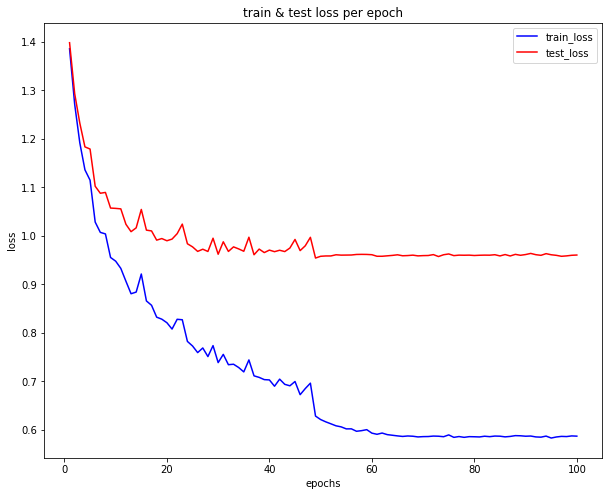

In [18]:
plt.figure(figsize=(10,8))

plt.plot(range(1, 101), train_loss, 'b-', label='train_loss')
plt.plot(range(1, 101), test_loss, 'r-', label='test_loss')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('train & test loss per epoch')
plt.legend()

plt.show()

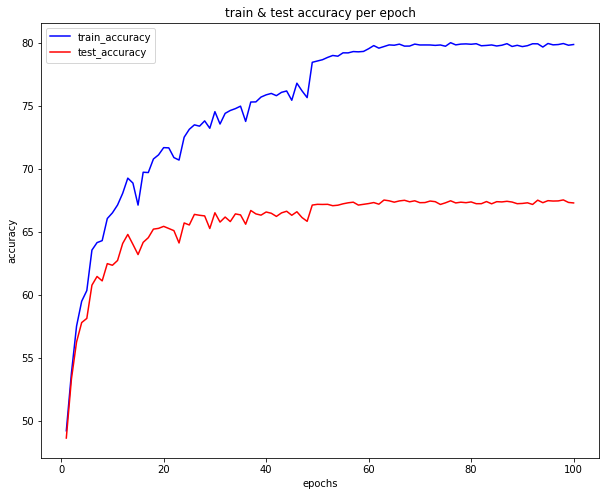

In [19]:
plt.figure(figsize=(10,8))

plt.plot(range(1, 101), train_accuracy, 'b-', label='train_accuracy')
plt.plot(range(1, 101), test_accuracy, 'r-', label='test_accuracy')

plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('train & test accuracy per epoch')
plt.legend()

plt.show()

In [20]:
print(f'Best epoch: {best_epoch}')
print(f'Train: accuracy: {best_train_accuracy:>0.1f}%, avg loss: {best_train_loss:>8f}')
print(f'Test: accuracy: {best_test_accuracy:>0.1f}%, avg loss: {best_test_loss:>8f}')

Best epoch: 98
Train: accuracy: 80.0%, avg loss: 0.585899
Test: accuracy: 67.5%, avg loss: 0.958519


## 5.4 Model metrics

In [21]:
print(f'Train:\n{classification_report(best_train_y, best_train_pred, target_names=target_names)}')
print(f'Test:\n{classification_report(best_test_y, best_test_pred, target_names=target_names)}')

Train:
              precision    recall  f1-score   support

    airplane       0.81      0.86      0.83      5000
  automobile       0.92      0.93      0.92      5000
        bird       0.76      0.68      0.72      5000
         cat       0.61      0.60      0.61      5000
        deer       0.75      0.79      0.77      5000
         dog       0.69      0.63      0.66      5000
        frog       0.85      0.86      0.85      5000
       horse       0.83      0.85      0.84      5000
        ship       0.88      0.91      0.89      5000
       truck       0.88      0.90      0.89      5000

    accuracy                           0.80     50000
   macro avg       0.80      0.80      0.80     50000
weighted avg       0.80      0.80      0.80     50000

Test:
              precision    recall  f1-score   support

    airplane       0.68      0.74      0.71      1000
  automobile       0.79      0.81      0.80      1000
        bird       0.60      0.51      0.55      1000
         ca

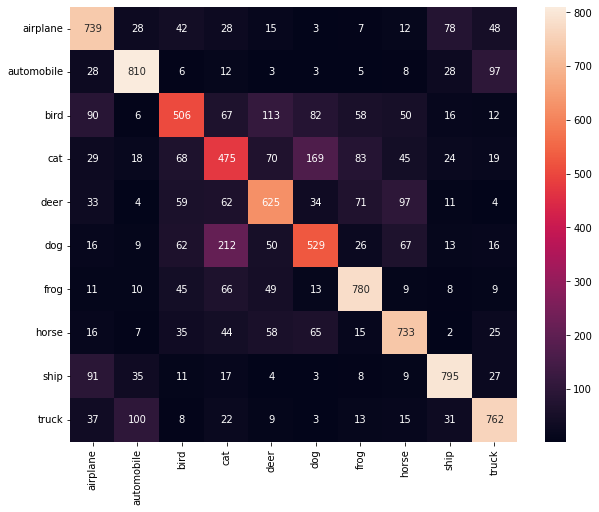

In [22]:
cm = confusion_matrix(best_test_y, best_test_pred)
sns.heatmap(cm, annot=True, fmt='', xticklabels=target_names, yticklabels=target_names, ax=plt.subplots(figsize=(10,8))[1])

## 5.5 Save model

In [ ]:
torch.save(best_model_state_dict, '../saved-model/cnn-weights.pth')